# **Garbage Classifier Performance Metrics**
### **ENEL 645**
#### **Group 5: Destin Saba, Cole Cathcart**

This notebook contains metrics and visualizations for analyzing the test set performance of a trained garbage classification model. The intended test set to use with this notebook is the CVPR_2024_dataset_Test, but other datasets will also work. The model itself is NOT trained in this notebook; please see the 'garbageClassifier.py' file for the code to train the model or download the saved model via the link found in the README file.

#### Instructions to run the notebook
1. To reduce code duplication, this notebook imports some classes directly from our classifier model. Please ensure that 'garbageClassifier.py' is in the same directory as this notebook before running.

2. Edit or uncomment the TEST_PATH variable below to point to the location of the dataset you wish to test the model on. This notebook assumes the directory is already organized into subdirectories based on class label.
3. Edit or uncomment the MODEL_PATH variable below to point to the location of the model.pth file. A model which was trained on the TALC cluster is available to download from google drive (link is in the README file).
4. Run all cells.

In [11]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models, datasets
import torch.nn as nn
import numpy as np
import os
from PIL import Image
from IPython.display import Image as im
from transformers import DistilBertTokenizer, DistilBertModel
from torchvision.models import ResNet50_Weights
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import json
import random
import warnings

warnings.filterwarnings('ignore')

#importing custom classes
from garbageClassifier import MultimodalGarbageDataset, MultimodalGarbageClassifier

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cuda


In [12]:
# Set path for test data and best model depending on where the notebook is
# being run

from google.colab import drive
drive.mount('/content/drive')
TEST_SET_PATH = "/content/drive/MyDrive/MENG/ENEL645/A2dataset/CVPR_2024_dataset_Test"
MODEL_PATH = "/content/drive/MyDrive/MENG/ENEL645/best_multimodal_model.pth"

# TEST_PATH = "/work/TALC/enel645_2025w/garbage_data/CVPR_2024_dataset_Test"
# TEST_PATH = "/path/to/local/dataset"
# MODEL_PATH = "./best_model.pth"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


We need to set up the test set and some other parameters before evaluation:

In [13]:
# Test set transformations
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Initialize tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
max_len = 24

# Create datasets
test_ds = MultimodalGarbageDataset(
    TEST_SET_PATH, tokenizer, max_len, transform=test_transform)

# Create data loaders
test_ld = DataLoader(test_ds, batch_size=16, shuffle=False, num_workers=2)

# Evaluation function
def evaluate_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        correct = 0
        total = 0
        for batch in test_loader:
            # Move data to device
            images = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            # Forward pass
            outputs = model(images, input_ids, attention_mask)
            probabilities = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)

            # Calculate accuracy
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Collect predictions and true labels
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probabilities.cpu().numpy())

    # Calculate accuracy
    accuracy = correct / total

    # Create classification report
    class_names = ['Black', 'Blue', 'Green', 'TTR']
    report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)

    # Create confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    return accuracy, report, cm, all_preds, all_labels, all_probs

# Function to predict a single image class
def predict_image(image_path, model, device, tokenizer, max_len):
    # Preprocess image
    image = Image.open(image_path).convert('RGB')
    image = test_transform(image).unsqueeze(0).to(device)

    # Tokenize image name
    image_name = os.path.basename(image_path)
    text = tokenizer(image_name, padding='max_length', max_length=max_len, truncation=True, return_tensors='pt')

    # Move text to device
    input_ids = text['input_ids'].to(device)
    attention_mask = text['attention_mask'].to(device)

    # Make prediction
    with torch.no_grad():
        outputs = model(image, input_ids, attention_mask)
        _, predicted = torch.max(outputs, 1)

    # Get class name
    class_names = ['Black', 'Blue', 'Green', 'TTR']
    predicted_class = class_names[predicted.item()]

    return predicted_class

Now we can load in the previously-trained best model for evaluation. This model was trained and tuned on the TALC cluster:

In [14]:
# Load in the best model
best_model = MultimodalGarbageClassifier(num_classes=4).to(device)
best_model.load_state_dict(torch.load(MODEL_PATH, map_location=device, weights_only=True))

# Evaluate
print("\nEvaluating multimodal model...")
accuracy, report, cm, all_preds, all_labels, probabilities = evaluate_model(best_model, test_ld, device)
print(f"Multimodal Model Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:")

# Print report
print(json.dumps(report, indent=4))


Evaluating multimodal model...
Multimodal Model Accuracy: 85.75%

Classification Report:
{
    "Black": {
        "precision": 0.7820710973724884,
        "recall": 0.7280575539568346,
        "f1-score": 0.7540983606557377,
        "support": 695.0
    },
    "Blue": {
        "precision": 0.8397271952259164,
        "recall": 0.9069981583793738,
        "f1-score": 0.8720672864099159,
        "support": 1086.0
    },
    "Green": {
        "precision": 0.9453621346886912,
        "recall": 0.9311639549436797,
        "f1-score": 0.9382093316519546,
        "support": 799.0
    },
    "TTR": {
        "precision": 0.8581818181818182,
        "recall": 0.8309859154929577,
        "f1-score": 0.8443649373881932,
        "support": 852.0
    },
    "accuracy": 0.8575174825174825,
    "macro avg": {
        "precision": 0.8563355613672285,
        "recall": 0.8493013956932114,
        "f1-score": 0.8521849790264504,
        "support": 3432.0
    },
    "weighted avg": {
        "precisio

Finally, we create some visualizaions to aid in analysis:

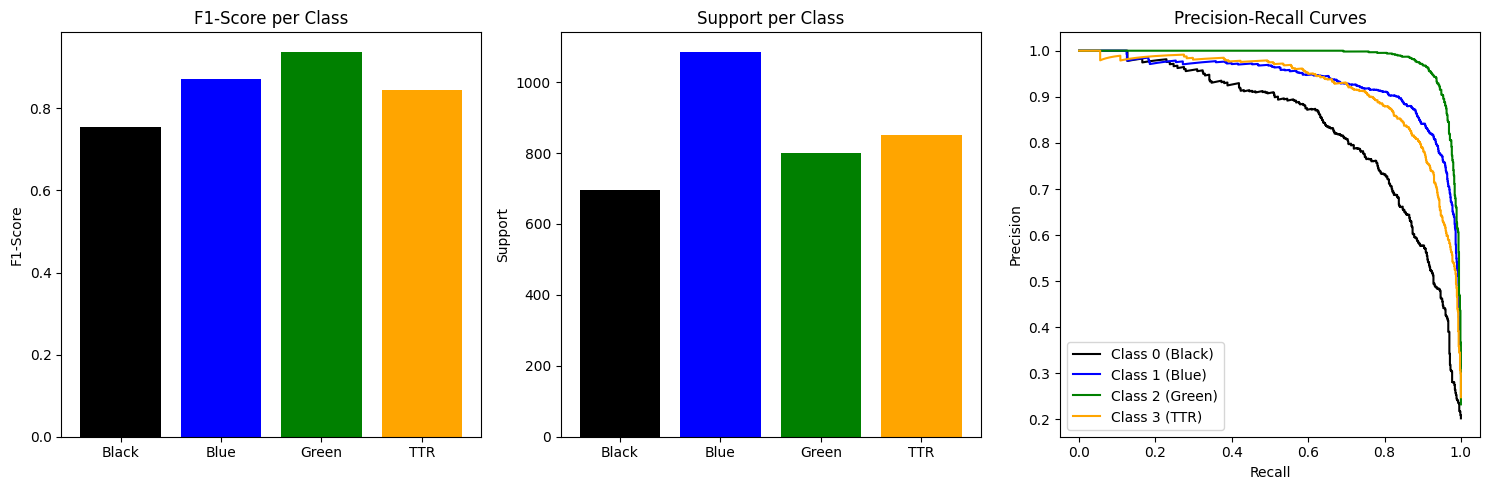

In [15]:
# Extract info from report
class_names = list(report.keys())[:-3]  # Exclude 'accuracy', 'macro avg', 'weighted avg'
precision = [report[class_name]['precision'] for class_name in class_names]
recall = [report[class_name]['recall'] for class_name in class_names]
f1_score = [report[class_name]['f1-score'] for class_name in class_names]
support = [report[class_name]['support'] for class_name in class_names]

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# F1-score plot
axes[0].bar(class_names, f1_score, color=['black', 'blue', 'green', 'orange'])
axes[0].set_title('F1-Score per Class')
axes[0].set_ylabel('F1-Score')

# Support plot
axes[1].bar(class_names, support, color=['black', 'blue', 'green', 'orange'])
axes[1].set_title('Support per Class')
axes[1].set_ylabel('Support')

# Binarize the true labels for one-vs-rest
y_true_bin = label_binarize(all_labels, classes=[0, 1, 2, 3])

all_probs = np.array(probabilities)


colors = ['black', 'blue', 'green', 'orange']
for i in range(4):
    precision_curve, recall_curve, _ = precision_recall_curve(y_true_bin[:, i], all_probs[:, i])
    axes[2].plot(recall_curve, precision_curve, color=colors[i], label=f'Class {i} ({class_names[i]})')

# Plot details
axes[2].set_title('Precision-Recall Curves')
axes[2].set_xlabel('Recall')
axes[2].set_ylabel('Precision')
axes[2].legend(loc='best')

plt.tight_layout()
plt.show()

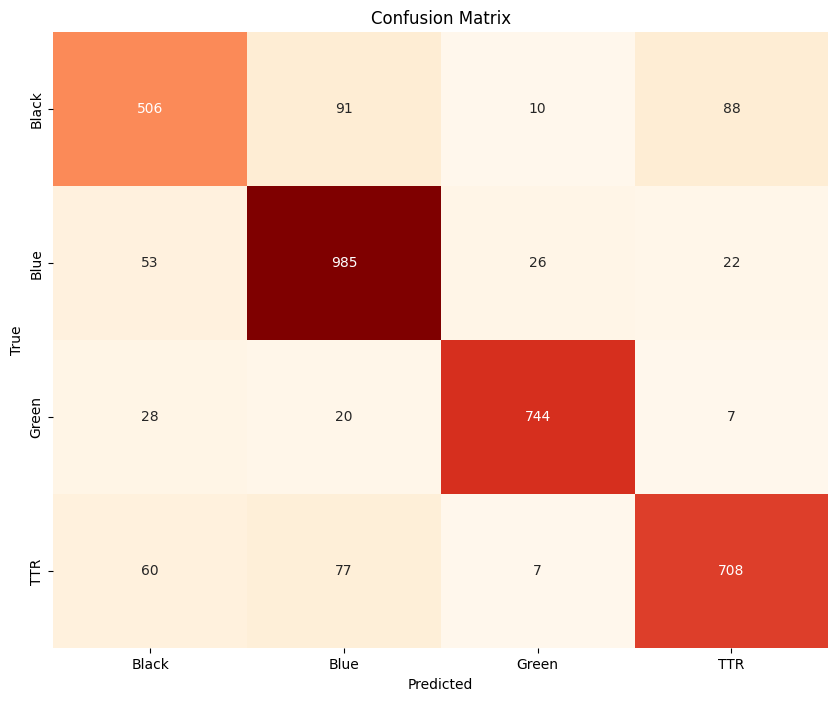

In [16]:
# Confusion matrix
class_names = ['Black', 'Blue', 'Green', 'TTR']
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='OrRd', xticklabels=class_names, yticklabels=class_names, cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

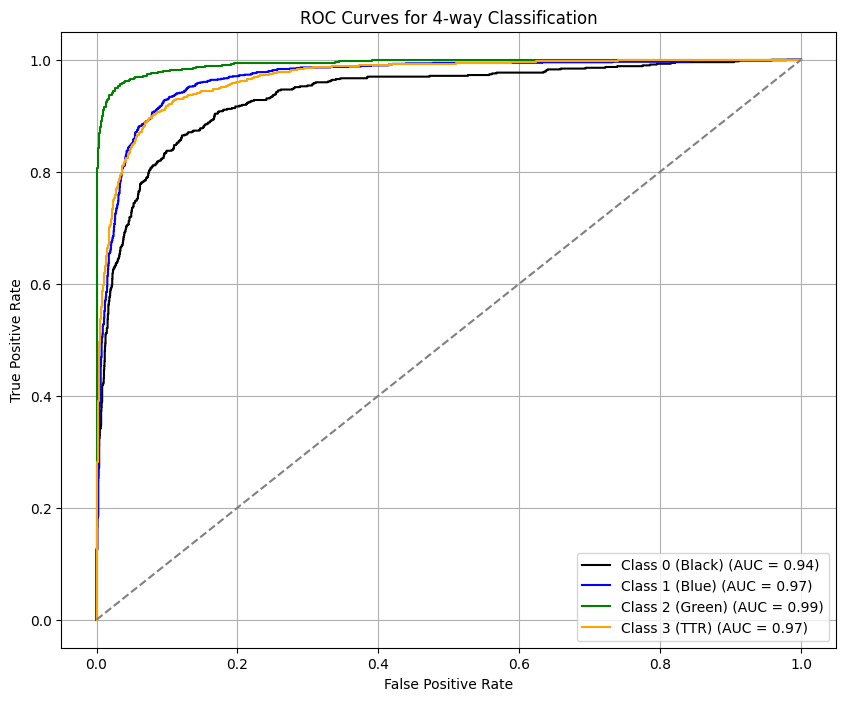

In [17]:
# ROC curve per-class

plt.figure(figsize=(10, 8))

# Loop through each class and plot ROC curve
for i in range(4):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], all_probs[:, i])
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve with specified color
    plt.plot(fpr, tpr, color=colors[i], label=f'Class {i} ({class_names[i]}) (AUC = {roc_auc:.2f})')

# Plot diagonal line for AUC
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# Plot details
plt.title('ROC Curves for 4-way Classification')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.grid(True)
plt.show()

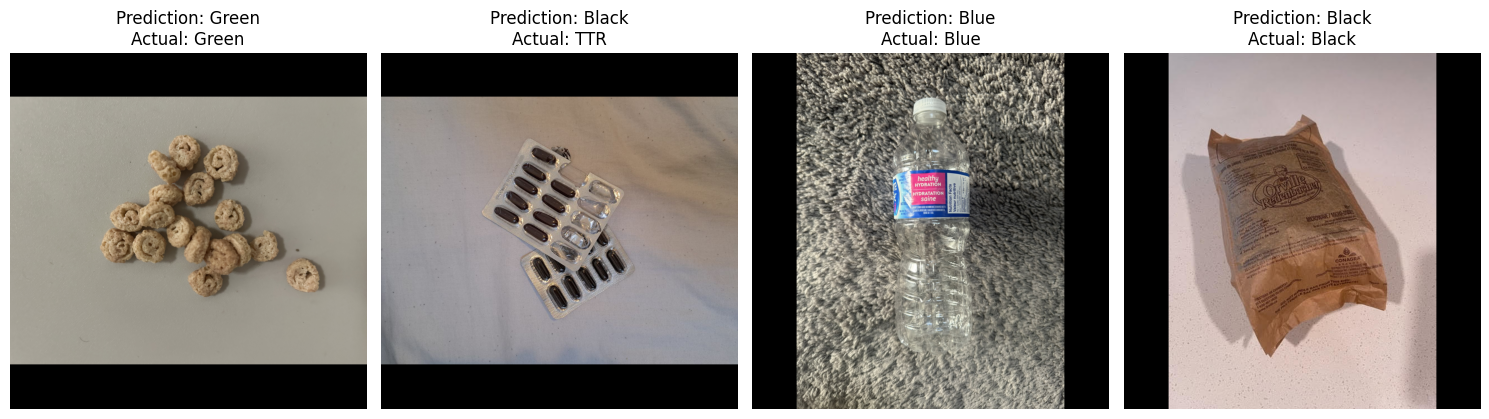

In [18]:
# Sample images with predictions

# Get 1 random image from each class
image_paths = []
for class_name in os.listdir(TEST_SET_PATH):
    class_path = os.path.join(TEST_SET_PATH, class_name)
    if os.path.isdir(class_path):
        image_paths.extend([os.path.join(class_path, filename) for filename in random.sample(os.listdir(class_path), 1)])

# Predict each image class and get actual class label
fig, axes = plt.subplots(1, len(image_paths), figsize=(15, 5))
for i, image_path in enumerate(image_paths):
    image = Image.open(image_path)
    axes[i].imshow(image)
    axes[i].axis('off')

    prediction = predict_image(image_path, best_model, device, tokenizer, max_len)

    actual_class = os.path.basename(os.path.dirname(image_path))

    axes[i].set_title(f'Prediction: {prediction}\nActual: {actual_class}')

plt.tight_layout()
plt.show()

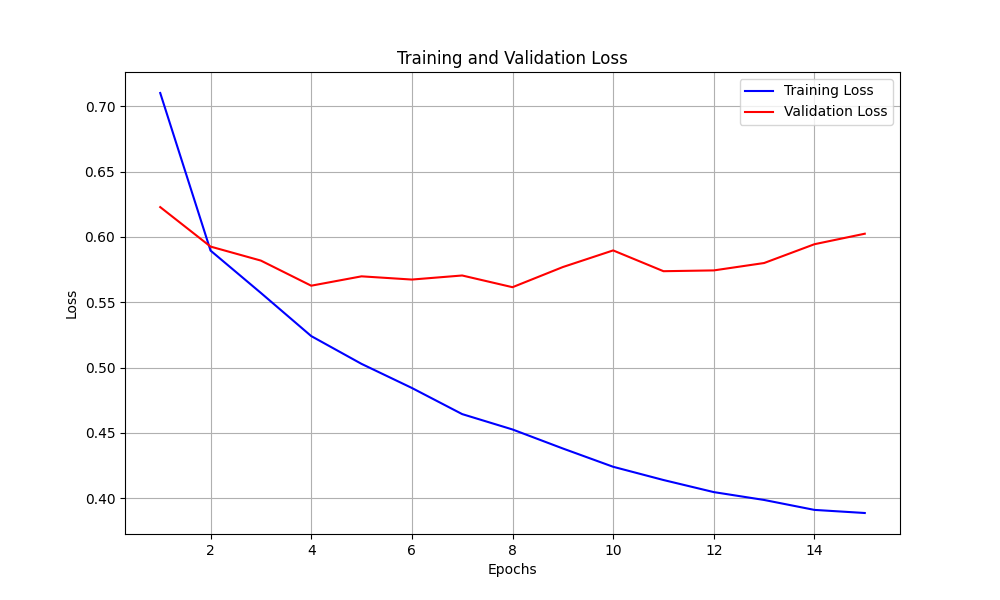

In [19]:
# Training and validation over time
# Note: This image was created during training on the TALC
# cluster and is included in the notebook for viewing convenience

im(filename='loss_curves.png')

# Analysis
Overall our model was able to achieve 0.8575 accuracy on the test dataset, which we believe constitues a a good fit and shows that the classifier performs well.  An even higher accuracy in the 0.9 range would have been ideal, but due to the limitations of this experiment (mainly the relatively small dataset size and inconsistent labels), we are happy with the results.

Unsurprisingly, while building the model we found that the text classifier consistently outperformed the image classifier. We attribute this to the dataset not being large enough for image classification, even with transfer-learning. However, we found that the multimodal image/text model outperformed both the individual image and text models, which shows there is a benefit to including the images.

This classification problem is also uniquely difficult, as there are some non-obvious rules about where certain items should be discarded, leading to situations where very similar-looking items need to be put in different bins. However, it remains likely that our classifier performs at least as well or even better than a human would at classifying garbage, and so in the context of the original framing of this model being used by the city we think we can label the experiment a success.

Looking at our tables allows a better understanding of the strengths and weaknesses of the classifier. From the confusion matrix, we can see that Black was by far the hardest label to classify correctly and Blue was the easiest. This is likely due to the ambiguity of the city's many rules for what goes in the black bin, while the blue bin tends to be restricted to a small handful of clean materials. Black also trails behind the other 3 classes in f1 score and AUC. We were surprised that Black was even harder to classify than Other (TTR) as the rules for special items tend to be even less obvious.

The final graph shows the change in training and validation loss during each epoch of the training stage. While training loss decreases over time, validation loss does not improve as much. This implies that the model is either overfitting or predicting classes with low confidence. Due to the small dataset, overfitting causing poor generalization is likely, but since the testing accuracy (and validation accuracy, not shown here) are quite high, low confidence is probably the main culprit.